In [4]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn 

import os


# Perf. vs Time (all experiments)

x-axis: -log2(time compared to DVGS) 
y-axis: perf compared to DVGS 

DVGS values will always lie at (1,1), all other experiment and methods will fall around this. Better performing/faster will have higher values. 



For performance, we'll use the area between filtered low and filtered high. 

In [5]:
def _parse_str_list(x): 
    return np.array([float(y) for y in x.strip('[]').split(',')])

In [14]:
dir_path = '../results/'

all_res = pd.concat([pd.read_csv(f'{dir_path}/{d}/results.csv', sep='\t') for d in os.listdir(dir_path) if os.path.exists(f'{dir_path}/{d}/results.csv')], axis=0)
all_res = all_res.assign(experiment=[x.split('/')[-1].split('.')[0] for x in all_res.config.values])

all_res.head()


,uid,config,config-checksum,method,perf_filter_low,perf_filter_high,runtime_s,experiment
0,543d04e2-fe22-4294-85cb-ee00c2b705eb,../configs/exp7.py,c899fe0d54c1ec27dadbe50396c76e7f,dvgs,"[0.9112001305677003, 0.9171357732025811, 0.912...","[0.9184318044626788, 0.9180561157640291, 0.912...",9374.095455,exp7
1,7f09de65-2be9-4daa-a7dd-1bda0c8eeb2a,../configs/exp7.py,c899fe0d54c1ec27dadbe50396c76e7f,random,"[0.9207200568118874, 0.9204739970301444, 0.918...","[0.9205017082601264, 0.9181951831809245, 0.920...",1407.881614,exp7
2,568f7458-d9b4-42b8-870e-f494bb249b31,../configs/exp7.py,c899fe0d54c1ec27dadbe50396c76e7f,dvgs,"[0.9153860190341488, 0.9178757657570887, 0.917...","[0.9144771440032583, 0.9174413958113453, 0.915...",8497.929981,exp7
3,4bfc5bd5-7fe1-44a2-9082-1899e4d2fa52,../configs/exp7.py,c899fe0d54c1ec27dadbe50396c76e7f,random,"[0.9213521982730217, 0.9204711382367253, 0.917...","[0.9189926150932818, 0.9210404449734882, 0.916...",1472.320385,exp7
4,36f238ff-64a2-4987-8d64-239ce5f56093,../configs/exp7.py,c899fe0d54c1ec27dadbe50396c76e7f,dvgs,"[0.9178301246122064, 0.919628579039666, 0.9193...","[0.918411087326227, 0.9183134880405383, 0.9153...",9765.141836,exp7


In [36]:
time_table = all_res.assign(**{'runtime (min)':lambda x: x.runtime_s / 60})[['method', 'runtime (min)', 'experiment']].groupby(['method', 'experiment']).mean().reset_index().pivot(index='method', columns='experiment', values='runtime (min)')
time_table

experiment,exp1,exp2,exp3,exp4,exp5,exp6,exp7,exp8
method,,,,,,,,
dshap,515.206759,774.884338,NaN,404.498001,631.001657,NaN,NaN,NaN
dvgs,1.313958,1.239720,5.308237,1.403390,1.340304,5.050090,153.997727,41.73748
dvrl,9.932999,9.451473,13.175151,9.759347,9.805979,11.705635,NaN,NaN
dvrl2,14.950120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loo,33.024054,34.036854,NaN,35.138252,34.652693,NaN,NaN,NaN
random,1.219050,1.178780,3.435092,1.244701,1.172593,3.044875,24.477245,NaN


In [43]:
(time_table / time_table.iloc[1,:]).mean(axis=1)
#(time_table / time_table.iloc[1,:]).std(axis=1)

method
dshap     444.042511
dvgs        1.000000
dvrl        5.708960
dvrl2      11.377925
loo        25.870254
random      0.721345
dtype: float64

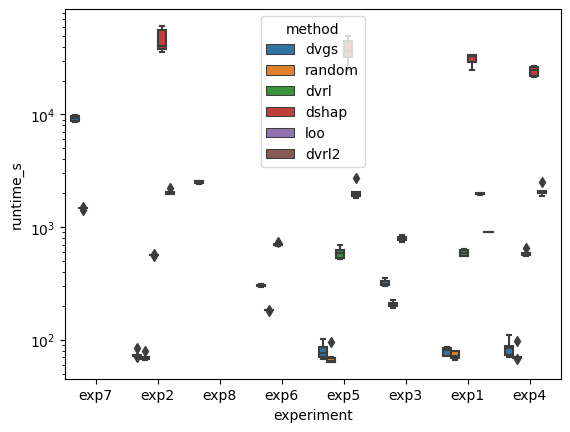

In [17]:
plt.figure()
sbn.boxplot(x='experiment', y='runtime_s', hue='method', data=all_res)
plt.yscale('log')
plt.show()

In [9]:
dir_path = '../results/'

exp_res = {d:pd.read_csv(f'{dir_path}/{d}/results.csv', sep='\t') for d in os.listdir(dir_path) if os.path.exists(f'{dir_path}/{d}/results.csv') }

df = {'method':[], 'exp':[], 'time_relative_to_dvgs':[], 'perf_relative_to_dvgs':[]}
for _,res in exp_res.items():
    try:  
        #print(res.head()); 3/0
        res = res[lambda x: x.method != 'apc']

        res = res.assign(perf_filter_low = lambda x: x.perf_filter_low.apply(_parse_str_list))
        res = res.assign(perf_filter_high = lambda x: x.perf_filter_high.apply(_parse_str_list))

        # step 1: get dvgs avg perf 
        dvgs_perf = (np.array(res[lambda x: x.method == 'dvgs'].perf_filter_low.values).mean(axis=0) - np.array(res[lambda x: x.method == 'dvgs'].perf_filter_high.values).mean(axis=0)).sum()

        # step 2: get dvgs avg time 
        dvgs_time = res[lambda x: x.method == 'dvgs'].runtime_s.mean()

        for i, row in res.iterrows(): 
            temp = row 
            method = row.method 
            exp = row.config.split('/')[-1][:-3]

            # get perf 
            perf = (temp.perf_filter_low - temp.perf_filter_high).sum()
            rel_perf = perf / dvgs_perf

            # get time 
            time = temp.runtime_s
            rel_time = -np.log2(time/dvgs_time)

            df['exp'].append(exp)
            df['method'].append(method)
            df['time_relative_to_dvgs'].append(rel_time)
            df['perf_relative_to_dvgs'].append(rel_perf)
    except: 
        pass

df = pd.DataFrame(df)
df.head()

,method,exp,time_relative_to_dvgs,perf_relative_to_dvgs
0,dvgs,exp7,-0.020808,0.824472
1,random,exp7,2.714346,0.068955
2,dvgs,exp7,0.120760,0.865609
3,random,exp7,2.649780,0.079238
4,dvgs,exp7,-0.079769,1.182982


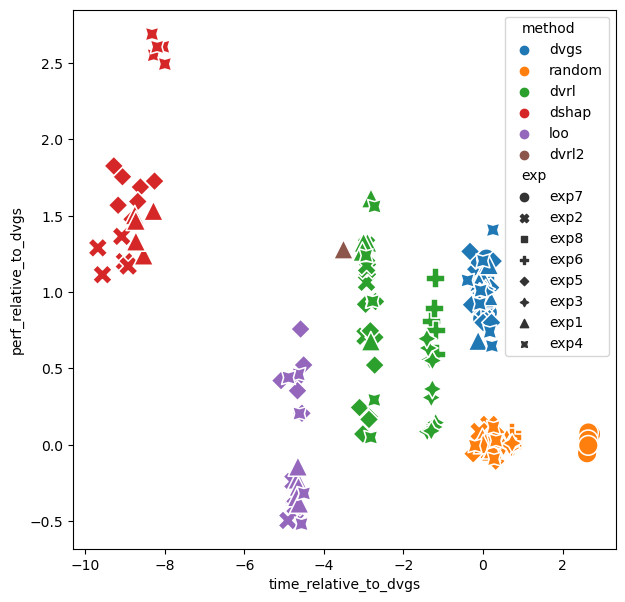

In [10]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='time_relative_to_dvgs', y='perf_relative_to_dvgs', hue='method', style='exp', data=df, s=200)
plt.show()